In [266]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

**Data Preprocessing Part 1**

In [45]:
#Open Dataset
parkinsons_data = pd.read_csv('parkinsons_disease_data.csv')
print(parkinsons_data.shape)
parkinsons_data.head()

(2105, 35)


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis,DoctorInCharge
0,3058,85,0,3,1,19.619878,0,5.108241,1.380660,3.893969,...,1.572427,1,0,0,0,0,0,0,0,DrXXXConfid
1,3059,75,0,0,2,16.247339,1,6.027648,8.409804,8.513428,...,4.787551,0,1,0,1,0,1,0,1,DrXXXConfid
2,3060,70,1,0,0,15.368239,0,2.242135,0.213275,6.498805,...,2.130686,1,0,0,0,1,0,1,1,DrXXXConfid
3,3061,52,0,0,0,15.454557,0,5.997788,1.375045,6.715033,...,3.391288,1,1,1,0,0,0,1,1,DrXXXConfid
4,3062,87,0,0,1,18.616042,0,9.775243,1.188607,4.657572,...,3.200969,0,0,0,1,0,1,0,0,DrXXXConfid


In [4]:
#Drop Irrelevant Features and Features That Already Identify Parkinsons (ie, UPDRS, MoCA, FunctionalAssessment)
pk_irr = parkinsons_data.drop('PatientID',axis=1)
pk_irr = pk_irr.drop('DoctorInCharge',axis=1)
pk_irr = pk_irr.drop('UPDRS',axis=1)
pk_irr = pk_irr.drop('MoCA',axis=1)
pk_irr = pk_irr.drop('FunctionalAssessment',axis=1)

In [5]:
##########################Function for Anomaly Removal###########################
def remove_anomalies(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    LB = Q1 - (IQR*1.5)
    UB = Q3 + (IQR*1.5)
    return (data - data[(data[feature]< LB) | (data[feature] > UB)])
###################################################################################

In [6]:
#Decouple Features and Target
pk_features = pk_irr.drop('Diagnosis',axis=1)
pk_target = pk_irr['Diagnosis']

In [7]:
#Apply SMOTE for class imbalance correction
smote = SMOTE()
pk_x_smote, pk_y_smote = smote.fit_resample(pk_features, pk_target)

**Data Visualization**

In [9]:
#Custom Palette For Visualizations
palette = {0: 'green', 1: 'red'}

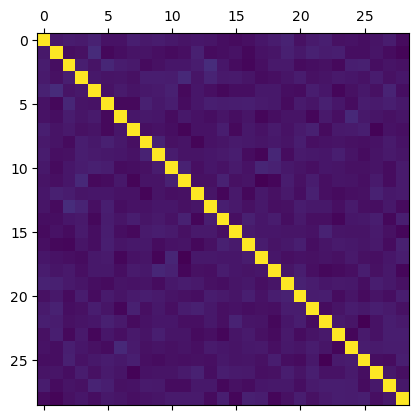

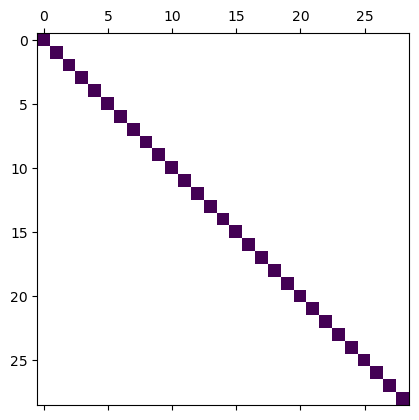

In [10]:
#Visualize Correlation
data_correlation = pk_features.corr()
data_high_correlation = data_correlation[abs(data_correlation) >= 0.5]
plt.matshow(data_correlation)
plt.matshow(data_high_correlation)

The above heatmap shows that none of the features in this dataset have a correlation above the cutoff we chose, which was 0.5. Therefore, there was no need to remove any features on account of correlation.

Diagnosis
1    1304
0     801
Name: count, dtype: int64


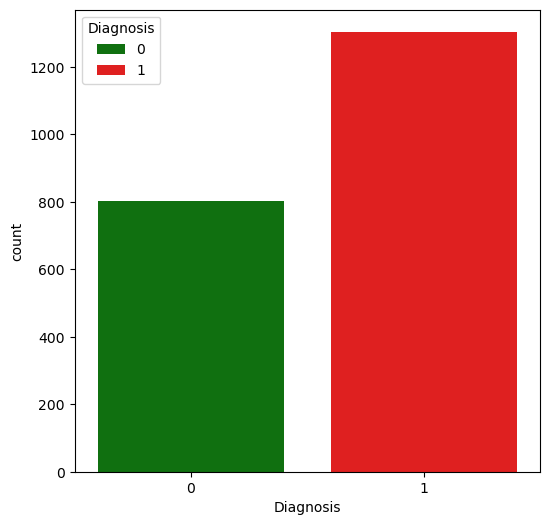

In [12]:
#Visualize Original Class Imbalance
print(pk_irr['Diagnosis'].value_counts())
plt.figure(figsize=(6, 6))
sns.countplot(x='Diagnosis', data=pk_irr, hue='Diagnosis', palette=palette)
plt.show()

There was a considerable class imbalance; most of the data points in the dataset were of the positive class (patients with parkinsons). This was corrected by applying SMOTE.

**Data Preprocessing Part 2**

In [15]:
#Scale Data
standard_scale = StandardScaler()
st_pk_x = standard_scale.fit_transform(pk_x_smote)

In [16]:
#Split Training and Testing Set
x_train, x_test, y_train, y_test = train_test_split(st_pk_x, pk_y_smote, train_size=.8, random_state=42)

**Feature Selection**

In [233]:
#Recursive Feature Elimination
#Basing RFE on a Logistic Regression Model since it's simple to train
elim_model = model = LogisticRegression(max_iter=1200, random_state=42)

feature_elim = RFE(estimator=elim_model, n_features_to_select=25)
feature_elim.fit(x_train, y_train)

#Take best features from this training and use for all future models
top_features = feature_elim.support_
x_train_s = x_train[:, top_features]
x_test_s = x_test[:, top_features]

#Retrieve Feature Names For Plotting
feature_names = pk_features.columns.tolist()
selected_feature_names = [name for name, selected in zip(feature_names, feature_elim.support_) if selected]

In [235]:
selected_feature_names

['Age',
 'Gender',
 'EducationLevel',
 'BMI',
 'Smoking',
 'AlcoholConsumption',
 'PhysicalActivity',
 'DietQuality',
 'SleepQuality',
 'FamilyHistoryParkinsons',
 'TraumaticBrainInjury',
 'Hypertension',
 'Diabetes',
 'Depression',
 'Stroke',
 'SystolicBP',
 'DiastolicBP',
 'CholesterolHDL',
 'CholesterolTriglycerides',
 'Tremor',
 'Rigidity',
 'Bradykinesia',
 'PosturalInstability',
 'SpeechProblems',
 'Constipation']

These are the 20 features the above feature elimination process has selected as the most important.

**First Model Implementation - Simple Logistic Regression**

In [239]:
#Fit Model
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train_s, y_train)

#Fit Model w/o Feature Selection for comparison
logreg_b = LogisticRegression(random_state=42)
logreg_b.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [241]:
#Make Predictions
logreg_pred = logreg.predict(x_test_s)
logreg_b_pred = logreg_b.predict(x_test)

**First Model Evaluation - Simple Logistic Regression**

With Feature Selection:
Accuracy: 0.7509578544061303
Precision: 0.7611940298507462
Recall: 0.7555555555555555
f1: 0.758364312267658


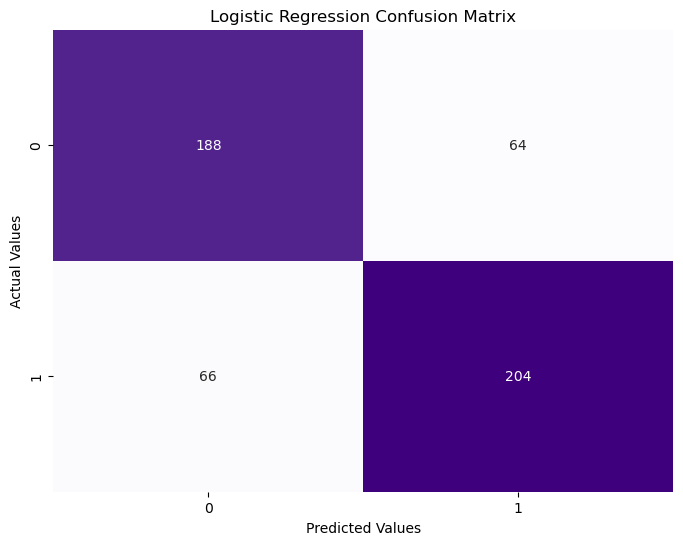


Without Feature Selection:
Accuracy: 0.7471264367816092
Precision: 0.7593984962406015
Recall: 0.7481481481481481
f1: 0.753731343283582


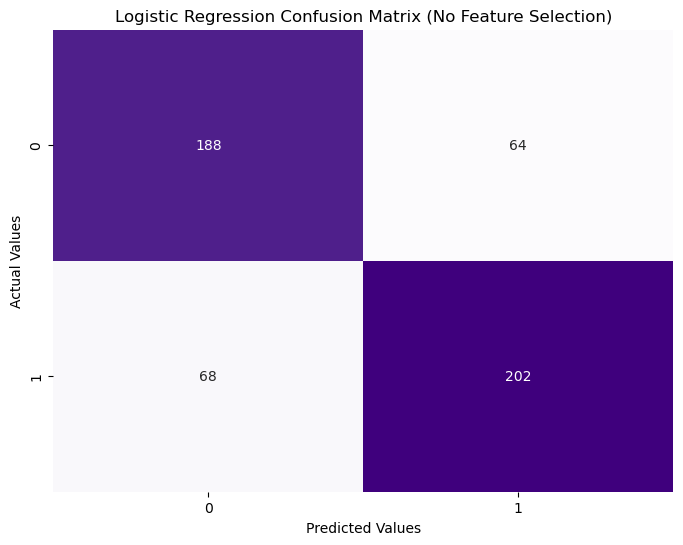

In [246]:
#With Feature Selection
lr_accuracy = accuracy_score(y_test, logreg_pred)
lr_precision = precision_score(y_test, logreg_pred)
lr_recall = recall_score(y_test, logreg_pred)
lr_f1 = f1_score(y_test, logreg_pred)
lr_confusion_matrix = confusion_matrix(y_test, logreg_pred)
print("With Feature Selection:")
print("Accuracy: " + str(lr_accuracy))
print("Precision: " + str(lr_precision))
print("Recall: " + str(lr_recall))
print("f1: " + str(lr_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(lr_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

#Without Feature Selection
lr_b_accuracy = accuracy_score(y_test, logreg_b_pred)
lr_b_precision = precision_score(y_test, logreg_b_pred)
lr_b_recall = recall_score(y_test, logreg_b_pred)
lr_b_f1 = f1_score(y_test, logreg_b_pred)
lr_b_confusion_matrix = confusion_matrix(y_test, logreg_b_pred)
print("\nWithout Feature Selection:")
print("Accuracy: " + str(lr_b_accuracy))
print("Precision: " + str(lr_b_precision))
print("Recall: " + str(lr_b_recall))
print("f1: " + str(lr_b_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(lr_b_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression Confusion Matrix (No Feature Selection)')
plt.show()

**First Model Visualization - Simple Logistic Regression**

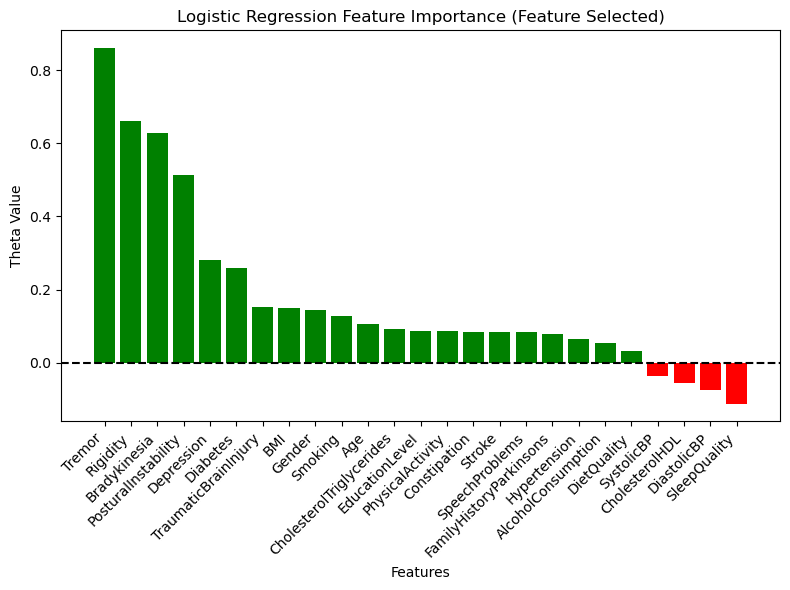

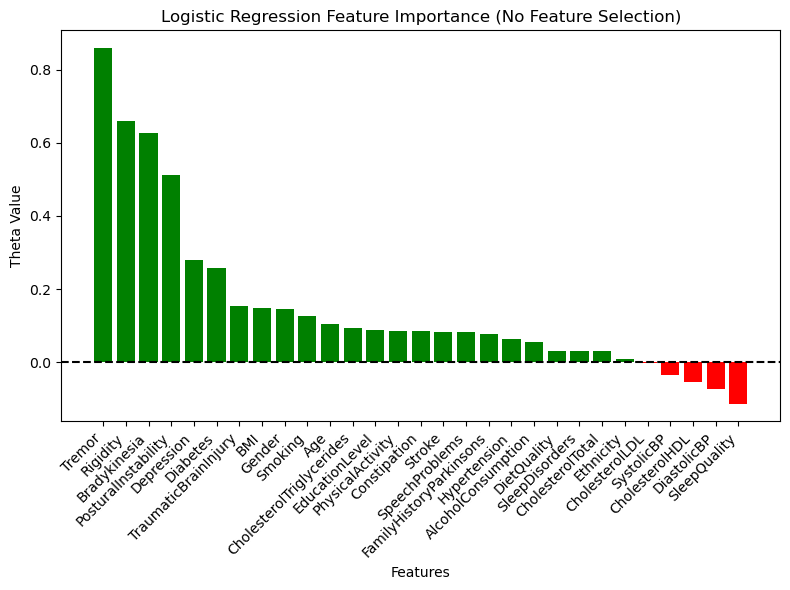

In [249]:
#With Feature Selection
logreg_thetas = pd.DataFrame({"Feature": selected_feature_names, "Thetas": logreg.coef_[0]}).sort_values(by="Thetas", ascending=False)
logreg_b_thetas =pd.DataFrame({"Feature": feature_names, "Thetas": logreg_b.coef_[0]}).sort_values(by="Thetas", ascending=False)

logreg_colors = ["green" if coef > 0 else "red" for coef in logreg_thetas["Thetas"]]
plt.figure(figsize=(8, 6))
plt.bar(logreg_thetas["Feature"], logreg_thetas["Thetas"], color=logreg_colors)
plt.axhline(0, color='black', linestyle='--')
plt.title("Logistic Regression Feature Importance (Feature Selected)")
plt.xlabel("Features")
plt.ylabel("Theta Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

logreg_b_colors = ["green" if coef > 0 else "red" for coef in logreg_b_thetas["Thetas"]]
plt.figure(figsize=(8, 6))
plt.bar(logreg_b_thetas["Feature"], logreg_b_thetas["Thetas"], color=logreg_b_colors)
plt.axhline(0, color='black', linestyle='--')
plt.title("Logistic Regression Feature Importance (No Feature Selection)")
plt.xlabel("Features")
plt.ylabel("Theta Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

These visualizations reveal huge influence from symptom features- notably, tremor, rigidity, bradykinesia, and depression. All other features seem to be decently important in determination of diagnosis in our linear models, except for Ethnicity and LDL Cholesterol as shown by the above graph in the model which is *not* feature selected.

**Second Model Implementation - SVM With Gaussian Kernel**

In [253]:
#Fit Model with Optimal Parameters Using GridSearchCV
svm_params = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]}
svm = GridSearchCV(estimator=SVC(kernel='rbf', random_state=42), param_grid=svm_params, scoring='accuracy')
svm.fit(x_train_s, y_train)

#Fit Model w/o Feature Selection for comparison
svm_b = GridSearchCV(estimator=SVC(kernel='rbf', random_state=42), param_grid=svm_params, scoring='accuracy')
svm_b.fit(x_train, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]},
             scoring='accuracy')

In [254]:
#Make Predictions
svm_pred = svm.predict(x_test_s)
svm_b_pred = svm_b.predict(x_test)

**Second Model Evaluation - SVM With Gaussian Kernel**

With Feature Selection:
Accuracy: 0.7375478927203065
Precision: 0.7209302325581395
Recall: 0.8037037037037037
F1 Score: 0.7600700525394045


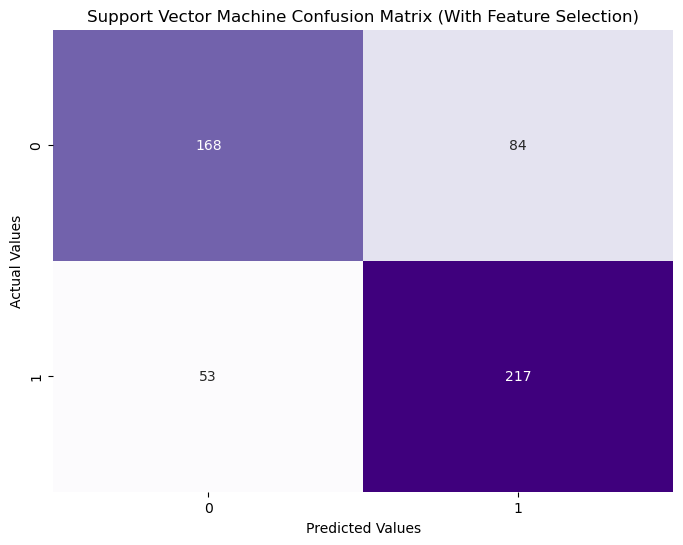


Without Feature Selection:
Accuracy: 0.7432950191570882
Precision: 0.7266666666666667
Recall: 0.8074074074074075
F1 Score: 0.7649122807017544


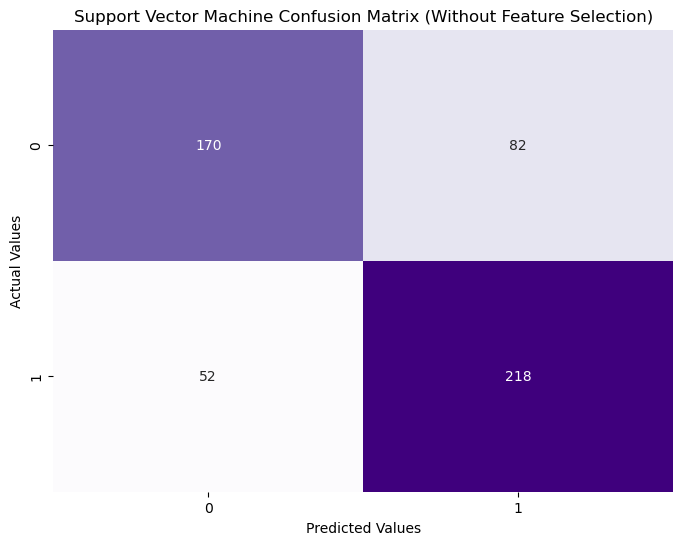

In [258]:
# With Feature Selection
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_confusion_matrix = confusion_matrix(y_test, svm_pred)
print("With Feature Selection:")
print("Accuracy: " + str(svm_accuracy))
print("Precision: " + str(svm_precision))
print("Recall: " + str(svm_recall))
print("F1 Score: " + str(svm_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(svm_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Support Vector Machine Confusion Matrix (With Feature Selection)')
plt.show()

# Without Feature Selection
svm_b_accuracy = accuracy_score(y_test, svm_b_pred)
svm_b_precision = precision_score(y_test, svm_b_pred)
svm_b_recall = recall_score(y_test, svm_b_pred)
svm_b_f1 = f1_score(y_test, svm_b_pred)
svm_b_confusion_matrix = confusion_matrix(y_test, svm_b_pred) 
print("\nWithout Feature Selection:")
print("Accuracy: " + str(svm_b_accuracy))
print("Precision: " + str(svm_b_precision))
print("Recall: " + str(svm_b_recall))
print("F1 Score: " + str(svm_b_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(svm_b_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Support Vector Machine Confusion Matrix (Without Feature Selection)')
plt.show()

It appears that this model does not benefit from the feature selection technique that was utilized in logistic regression; in fact, removing features seems to make the model worse. Since Gaussian Kernel SVMs leverage dimensionality, this makes sense from a theoretical standpoint.

**Second Model Visualization - SVM With Gaussian Kernel (TODO)**

Insert something here

**Third Model Implementation - Decision Tree**

In [264]:
#Fit Decision Tree with Optimal Parameters Using GridSearchCV
dt_params = {'max_depth': [5, 10, 15, None], 'criterion': ['gini', 'entropy'],'min_samples_split': [5, 10], 'min_samples_leaf': [1, 2, 4]}
dtree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=dt_params, scoring='accuracy', cv=5)
dtree_b = copy.deepcopy(dtree)
dtree.fit(x_train_s, y_train)
dtree_b.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10]},
             scoring='accuracy')

In [228]:
#Make Predictions
dt_pred = dtree.predict(x_test_s)
dt_b_pred = dtree_b.predict(x_test)

**Third Model Evaluation - Decision Tree**

With Feature Selection:
Accuracy: 0.7279693486590039
Precision: 0.6987577639751553
Recall: 0.8333333333333334
F1 Score: 0.7601351351351351


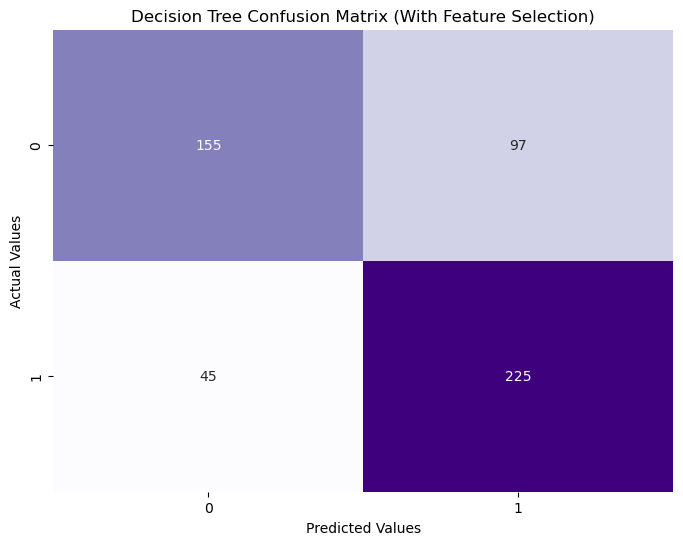


Without Feature Selection:
Accuracy: 0.7279693486590039
Precision: 0.6987577639751553
Recall: 0.8333333333333334
F1 Score: 0.7601351351351351


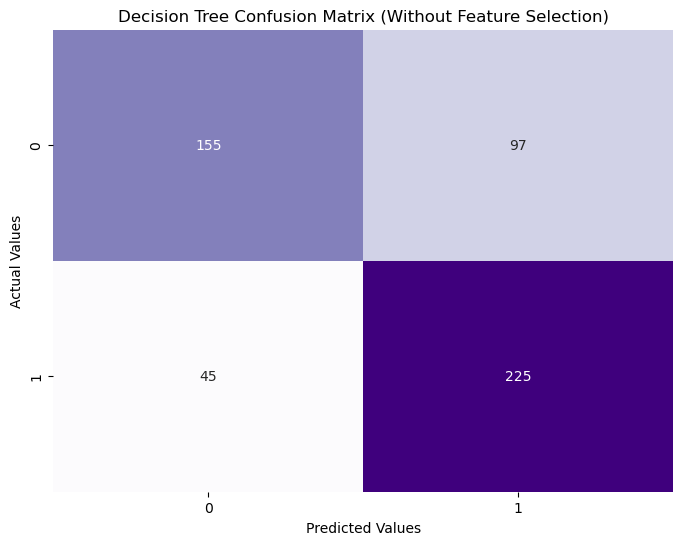

In [231]:
# With Feature Selection
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_confusion_matrix = confusion_matrix(y_test, dt_pred)
print("With Feature Selection:")
print("Accuracy: " + str(dt_accuracy))
print("Precision: " + str(dt_precision))
print("Recall: " + str(dt_recall))
print("F1 Score: " + str(dt_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(dt_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Decision Tree Confusion Matrix (With Feature Selection)')
plt.show()

#Without Feature Selection
dt_b_accuracy = accuracy_score(y_test, dt_b_pred)
dt_b_precision = precision_score(y_test, dt_b_pred)
dt_b_recall = recall_score(y_test, dt_b_pred)
dt_b_f1 = f1_score(y_test, dt_b_pred)
dt_b_confusion_matrix = confusion_matrix(y_test, dt_b_pred) 
print("\nWithout Feature Selection:")
print("Accuracy: " + str(dt_b_accuracy))
print("Precision: " + str(dt_b_precision))
print("Recall: " + str(dt_b_recall))
print("F1 Score: " + str(dt_b_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(dt_b_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Decision Tree Confusion Matrix (Without Feature Selection)')
plt.show()

**Third Model Visualization - Decision Tree**

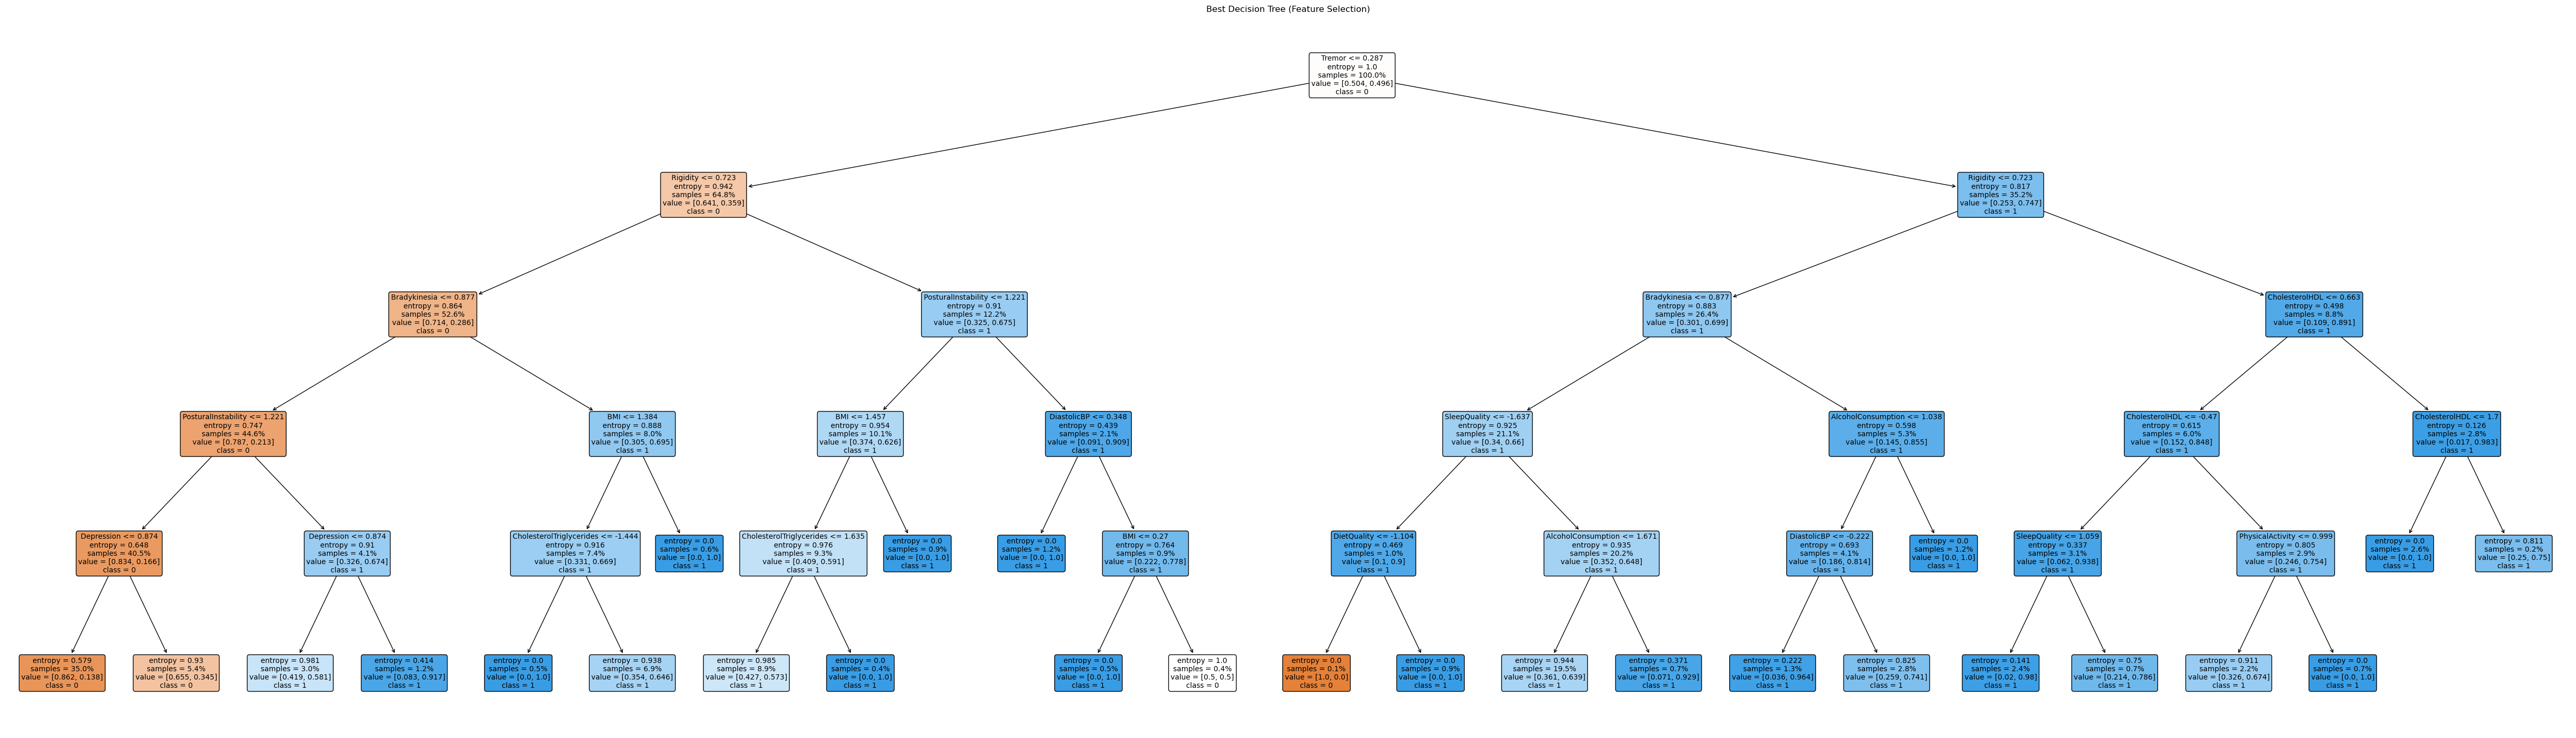

In [294]:
#Show Tree With Feature Selection Applied
plt.figure(figsize=(64, 18))
plot_tree(dtree.best_estimator_, feature_names=selected_feature_names, class_names=["0", "1"], filled=True, rounded=True, proportion=True, fontsize=10)
plt.title("Best Decision Tree (Feature Selection)")
plt.show()

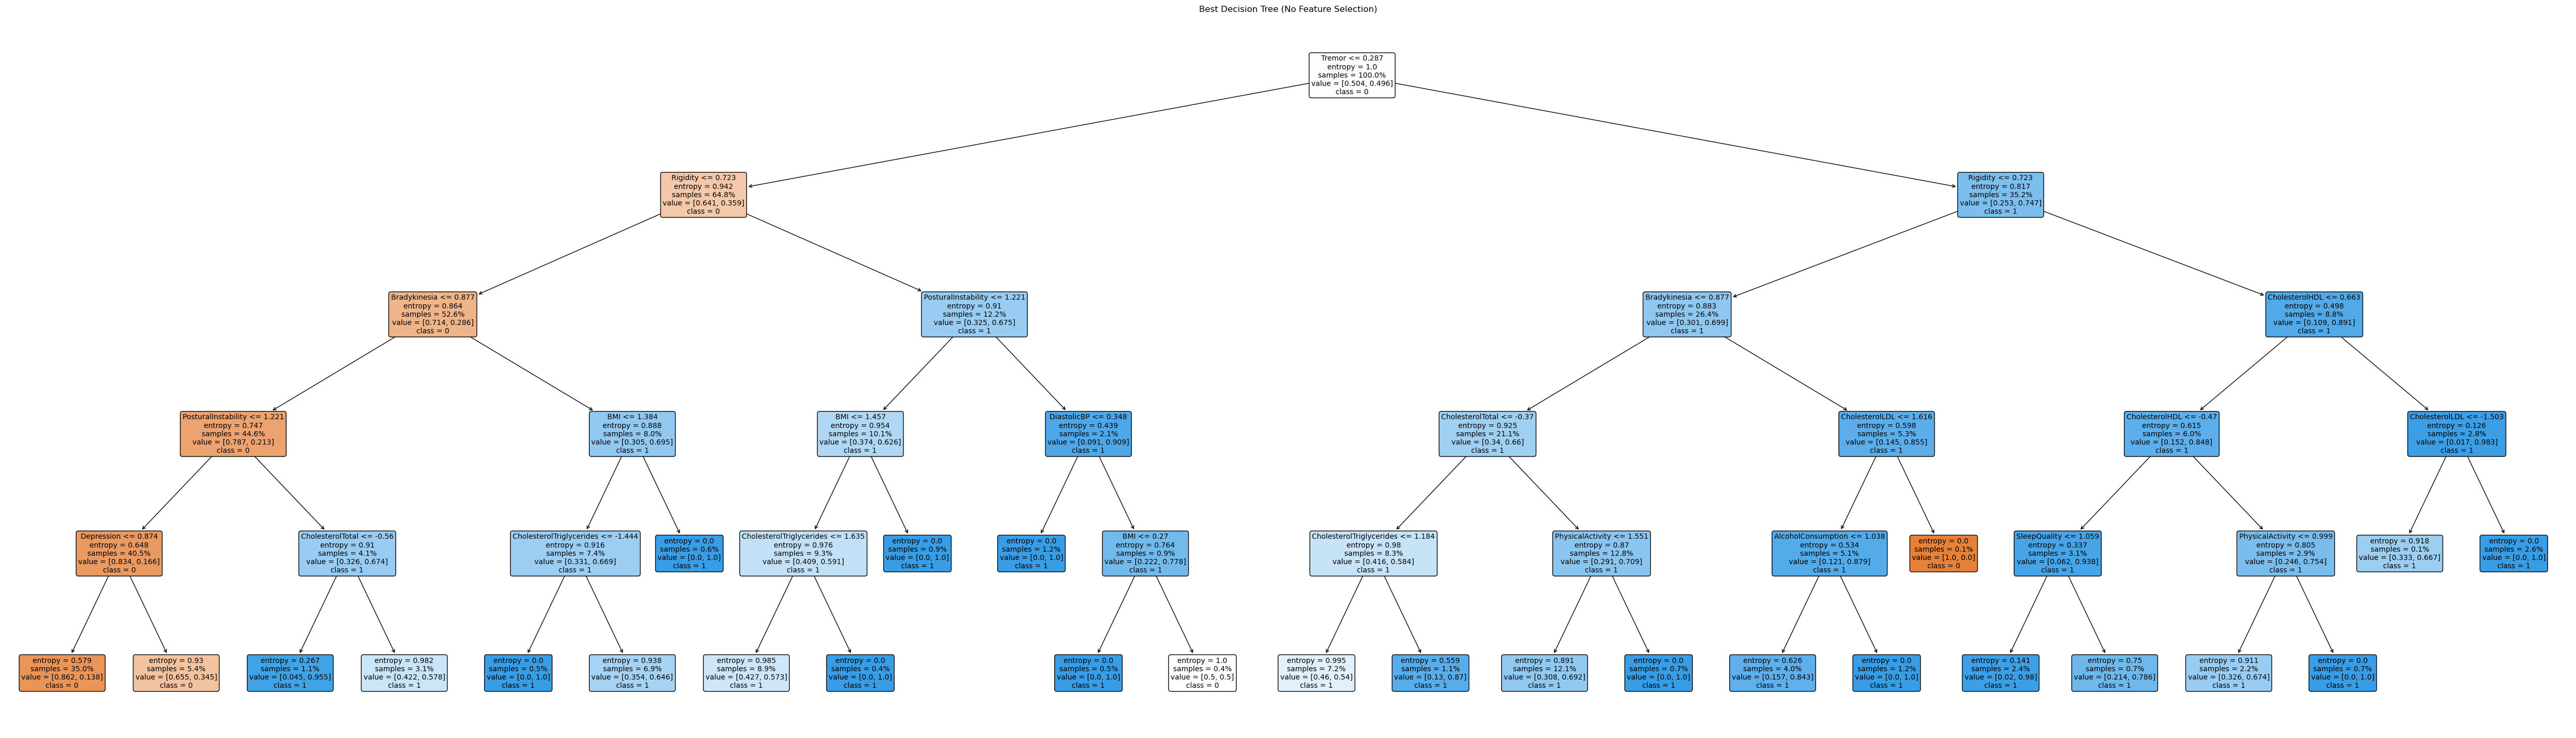

In [296]:
#Show Tree With No Feature Selection Applied
plt.figure(figsize=(64, 18))
plot_tree(dtree_b.best_estimator_, feature_names=feature_names, class_names=["0", "1"], filled=True, rounded=True, proportion=True, fontsize=10)
plt.title("Best Decision Tree (No Feature Selection)")
plt.show()

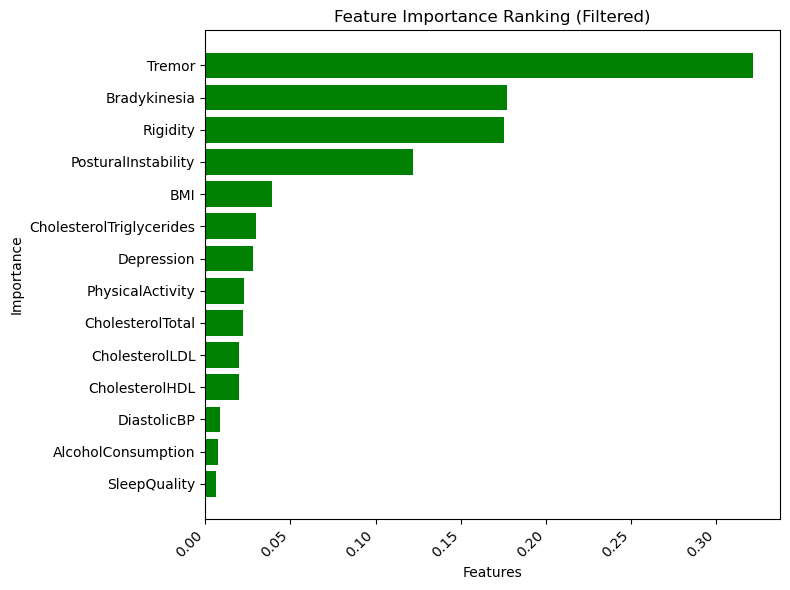

In [310]:
#Show Most Important Features From Full Tree
dtree_b_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": dtree_b.best_estimator_.feature_importances_
})
dtree_b_imp = dtree_b_imp[dtree_b_imp["Importance"] > 0]
dtree_b_imp = dtree_b_imp.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(dtree_b_imp["Feature"], dtree_b_imp["Importance"], color=logreg_colors)
plt.xticks(rotation=45, ha="right")
plt.title("Feature Importance Ranking (Filtered)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

The above are features the tree has determined are most important; they mostly agree with the logistic regression features. Like logistic regression, the decisiont tree model attributes the most importance to clinical symptoms. Interestingly, age, which had a small but notable importance in the 